In [1]:
import pandas as pd
import numpy as np
import gzip
import json
import matplotlib.pyplot as plt
def parse(path):
    g = gzip.open(path, 'rb')
    for l in g:
        yield json.loads(l)  # Using json.loads instead of eval()

def getDF(path):
    i = 0
    df = {}
    for d in parse(path):
        df[i] = d
        i += 1
    return pd.DataFrame.from_dict(df, orient='index')



In [2]:
df = getDF('../data/Cell_Phones_and_Accessories_5.json.gz')

In [3]:
df.sample(5)

,overall,verified,reviewTime,reviewerID,asin,style,reviewerName,reviewText,summary,unixReviewTime,vote,image
143931,5.0,True,"04 29, 2013",A16N5Y4S4W1AKL,B0094NZ8BK,NaN,Nichole Jacobs,They are so cute and durable for the phone . I...,Great,1367193600,NaN,NaN
425108,5.0,True,"05 29, 2014",A2XEW5XP3W5M0S,B00JW58JQ6,{'Color:': ' Black'},Melody,This looks exactly as pictured.. Very nice.. S...,Perfect,1401321600,NaN,NaN
711926,3.0,True,"10 22, 2014",A3FX98JXPWA9JI,B00JZ057AE,NaN,DONALD JOHNSON,flimsy lock,Three Stars,1413936000,NaN,NaN
893439,5.0,True,"06 9, 2016",A137HDG72N3ZG6,B0188GYMDS,NaN,Consumer,Perfect fit. Easy to install! Great! Fits my...,Five Stars,1465430400,NaN,NaN
800093,5.0,True,"02 17, 2016",A1HDJFATPPS8O1,B0128XEZJS,{'Color:': ' Dashboard Car Mount'},nmh5001,I like the sticky gel built into the rim of th...,Sticky Suction,1455667200,NaN,NaN


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1128437 entries, 0 to 1128436
Data columns (total 12 columns):
 #   Column          Non-Null Count    Dtype  
---  ------          --------------    -----  
 0   overall         1128437 non-null  float64
 1   verified        1128437 non-null  bool   
 2   reviewTime      1128437 non-null  object 
 3   reviewerID      1128437 non-null  object 
 4   asin            1128437 non-null  object 
 5   style           605241 non-null   object 
 6   reviewerName    1128302 non-null  object 
 7   reviewText      1127672 non-null  object 
 8   summary         1127920 non-null  object 
 9   unixReviewTime  1128437 non-null  int64  
 10  vote            92034 non-null    object 
 11  image           27107 non-null    object 
dtypes: bool(1), float64(1), int64(1), object(9)
memory usage: 104.4+ MB


We see that we have 12 columns in total. We have the star review, whether the review is verified, the review time, ID of reviewer, some keys to link to the product data, the name of the reviewer, the actual text review, the summary review as well as whether their review was marked as helpful, and some images of the product. 

## Data Dictionary

| Column name    | Datatype | Measures| Notes|
| -------------- | -------- | ---------------------------------------------------- | --------------------------------------- |
| overall        | float    | Overall star rating of review   |                                         |
| verified       | boolean  | Whether the review has been verified as real or not. | |
| reviewTime     | object   | Time of review    | If needed can change type to datetime64 |
| reviewerID     | object   | Unique ID of reviewer                                |                                         |
| asin           | object   | Product metadata  |Amazon Standard Identification Number|
| style          | object   | Product metadata                                     |                                         |
| reviewerName   | object   | Name of reviewer                                     |                                         |
| reviewText     | object   | Textual contents of review                           |                                         |
| summary        | object   | Textual summary of review                            |                                         |
| unixReviewTime | int64    | Time of review since Unix Epoch on January 1st, 1970 |                                         |
| vote           | object   | Count of usefulness vote                             |                                         |
| image          | object   | Image of product reviewed                            |                                         |

In [5]:
df.isna().sum()

overall                 0
verified                0
reviewTime              0
reviewerID              0
asin                    0
style              523196
reviewerName          135
reviewText            765
summary               517
unixReviewTime          0
vote              1036403
image             1101330
dtype: int64

In [6]:
(df.isna().sum())/(df.shape[0])

overall           0.000000
verified          0.000000
reviewTime        0.000000
reviewerID        0.000000
asin              0.000000
style             0.463647
reviewerName      0.000120
reviewText        0.000678
summary           0.000458
unixReviewTime    0.000000
vote              0.918441
image             0.975978
dtype: float64

We see that we have nulls for some reviews as well as other metadata. These will not be helpful for us

In [7]:
df[['overall']].value_counts(normalize=True)

overall
5.0        0.626564
4.0        0.163439
3.0        0.087071
1.0        0.072258
2.0        0.050667
Name: proportion, dtype: float64

In [8]:
df['verified'].value_counts(normalize=True)

verified
True     0.874948
False    0.125052
Name: proportion, dtype: float64

we only want verified reviews:

"After someone submits a review, we check if they:

Bought or used the item on Amazon;
Paid a price available to most Amazon shoppers.
If we confirm both, we label the review as Verified Purchase."

Lets make a simplified version of our data containing only rating and text review and summary, including only the verified reviews containing textual data.

Entires with no review won't be too helpful, so we can drop them. 

In [9]:
def simplifyReviews(dataframe):
    '''
    assumes data from amazon reviews, outputs new dataframe with only verified reviews containing overall rating, review and summary

    '''
    out = dataframe.copy()
    out = out[["overall", "verified", "reviewText", "summary"]]
    out = out[out["verified"]==True]
    out = out.drop("verified", axis=1)
    out.info()
    out = out.dropna()
    return out
    

Here is a function that plots the rating distribution of a sample of data it is passed. This will be useful also later.

In [10]:
def rating_distribution(data):

    values, counts = np.unique(data['overall'], return_counts=True)
    normalized_counts = counts/counts.sum()

    plt.figure()
    plt.bar(values, normalized_counts * 100)
    plt.xlabel("Review rating")
    plt.ylabel('% of reviews')
    plt.title("Rating distribution")
    plt.show()
    return normalized_counts
    

In [11]:
# df1 = pd.read_csv("../data/clean_technology_reviews.csv")
# we have already loaded in the technology reviews

In [12]:
df2 = getDF("../data/Office_Products_5.json.gz")


In [13]:
df3 = getDF("../data/Toys_and_Games_5.json.gz")


In [14]:
tech_simple = simplifyReviews(df)
office_simple = simplifyReviews(df2)
toys_simple = simplifyReviews(df3)

<class 'pandas.core.frame.DataFrame'>
Index: 987324 entries, 0 to 1128436
Data columns (total 3 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   overall     987324 non-null  float64
 1   reviewText  986589 non-null  object 
 2   summary     986849 non-null  object 
dtypes: float64(1), object(2)
memory usage: 30.1+ MB
<class 'pandas.core.frame.DataFrame'>
Index: 710187 entries, 0 to 800356
Data columns (total 3 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   overall     710187 non-null  float64
 1   reviewText  709987 non-null  object 
 2   summary     710066 non-null  object 
dtypes: float64(1), object(2)
memory usage: 21.7+ MB
<class 'pandas.core.frame.DataFrame'>
Index: 1599831 entries, 0 to 1828970
Data columns (total 3 columns):
 #   Column      Non-Null Count    Dtype  
---  ------      --------------    -----  
 0   overall     1599831 non-null  float64
 1   reviewText  1598728 no

In [15]:
# Save these as csvs

# tech_simple.to_csv("../data/clean_technology_reviews.csv")
# office_simple.to_csv("../data/clean_office_reviews.csv")
# toys_simple.to_csv("../data/clean_toys_reviews.csv")

In [16]:
# once made as csvs can use these instead:
# df1 = pd.read_csv("../data/clean_technology_reviews.csv")

In [17]:
# df2 = pd.read_csv("../data/clean_office_reviews.csv")


In [18]:
# df3 = getDF("Toys_and_Games_5.json.gz")


In [19]:
tech_simple.sample(5)

,overall,reviewText,summary
631848,5.0,My Father's wife loved the case. She couldn't ...,Five Stars
1062636,4.0,can't beat the price,Four Stars
486470,1.0,I finally got around to making a review on thi...,I finally got around to making a review on thi...
734170,5.0,A very good deal compared to most.,A very good deal
557862,5.0,finally I have a wall charger that actually wo...,Five Stars


We can read in the data from these csvs in future.
We will analyze the rating distributions of three specific Amazon product categories. We've selected these particular categories because their reviews more accurately reflect sentiments about the actual products, as opposed to categories like books or video games, where reviews might primarily address the content rather than the product itself.

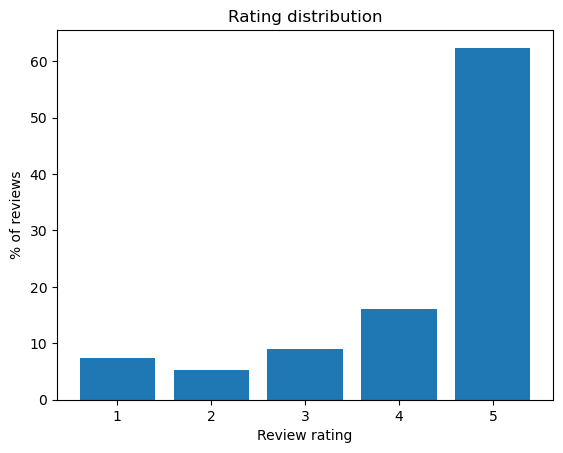

array([0.07475422, 0.05216571, 0.08910983, 0.15997424, 0.62399598])

In [20]:
rating_distribution(tech_simple)

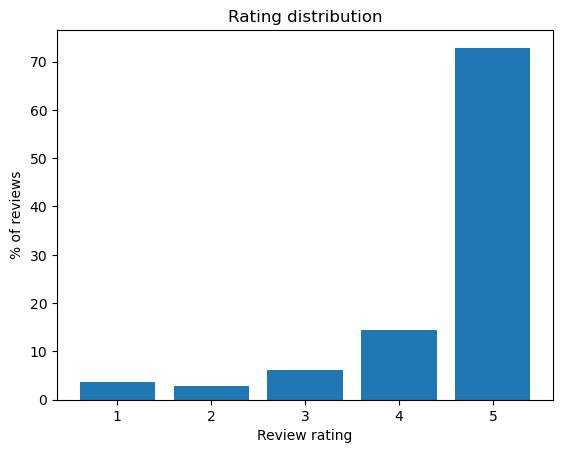

array([0.0365442 , 0.02863442, 0.06099341, 0.14521328, 0.7286147 ])

In [21]:
rating_distribution(office_simple)

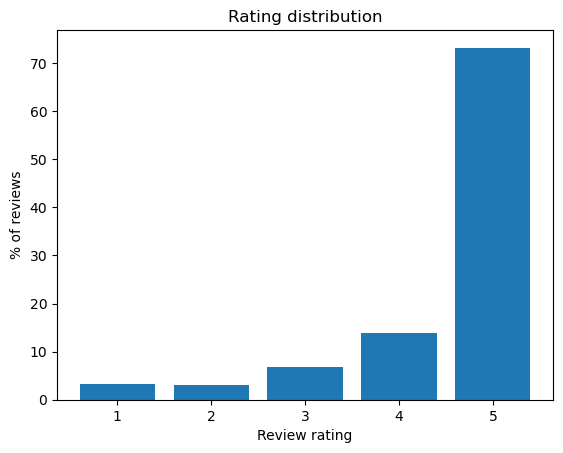

array([0.03177404, 0.02984212, 0.06805442, 0.13868264, 0.73164678])

In [22]:
rating_distribution(toys_simple)

In [23]:
pd.DataFrame(np.unique(tech_simple['overall'], return_counts=True))

,0,1,2,3,4
0,1.0,2.0,3.0,4.0,5.0
1,73720.0,51444.0,87877.0,157761.0,615363.0


In [24]:
pd.DataFrame(np.unique(office_simple['overall'], return_counts=True))

,0,1,2,3,4
0,1.0,2.0,3.0,4.0,5.0
1,25942.0,20327.0,43298.0,103084.0,517229.0


In [25]:
pd.DataFrame(np.unique(toys_simple['overall'], return_counts=True))

,0,1,2,3,4
0,1.0,2.0,3.0,4.0,5.0
1,50788.0,47700.0,108779.0,221672.0,1169473.0


We see that the majority of the reviews are 5 stars, in the tech reviews, "only" 62% are 5 star, so I will use this as it is lowest. For modelling, we will need to come back and address this issue later 

In [26]:
tech_simple.head(5)

,overall,reviewText,summary
0,5.0,Looks even better in person. Be careful to not...,Can't stop won't stop looking at it
1,5.0,When you don't want to spend a whole lot of ca...,1
2,3.0,"so the case came on time, i love the design. I...",Its okay
3,2.0,DON'T CARE FOR IT. GAVE IT AS A GIFT AND THEY...,CASE
4,4.0,"I liked it because it was cute, but the studs ...",Cute!


It will be useful to know the length of a review

In [27]:
rev_len = list()
for review in tech_simple["reviewText"]:
    rev_len.append(len(review))

In [28]:
tech_simple["length"] = rev_len

In [29]:
tech_simple["length"].describe()

count    986165.000000
mean        209.004199
std         363.109492
min           1.000000
25%          34.000000
50%         108.000000
75%         240.000000
max       33457.000000
Name: length, dtype: float64

We see that most reviews are between 34 and 240 characters long with a max of 33,457. We will probably not be able to analyse full essays but it will be useful before eliminating any to see if there is a relationship between review length and overall star rating 

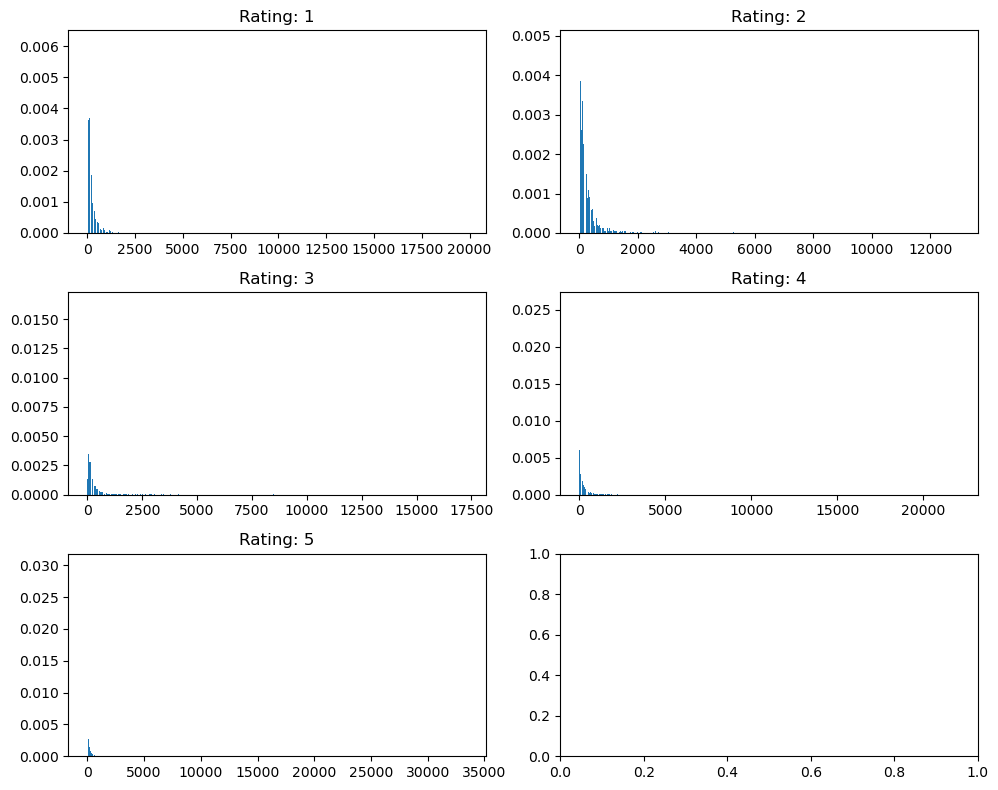

In [30]:
plt.subplots(3,2, figsize=(10,8))
for i in range(1,6):
    len_dist = tech_simple["length"][tech_simple["overall"]==i].value_counts().reset_index()
    len_dist['count_norm']=len_dist['count']/len_dist["count"].sum()
    plt.subplot(3,2,i)
    # plt.bar(len_dist["length"],len_dist['count'])
    plt.bar(len_dist["length"],len_dist['count_norm'])
    plt.title(f"Rating: {i}")
plt.tight_layout()
plt.show()

It is clear we should remove the absolute outliers

In [31]:
tech_simple2 = tech_simple[tech_simple["length"]<=2500].copy()


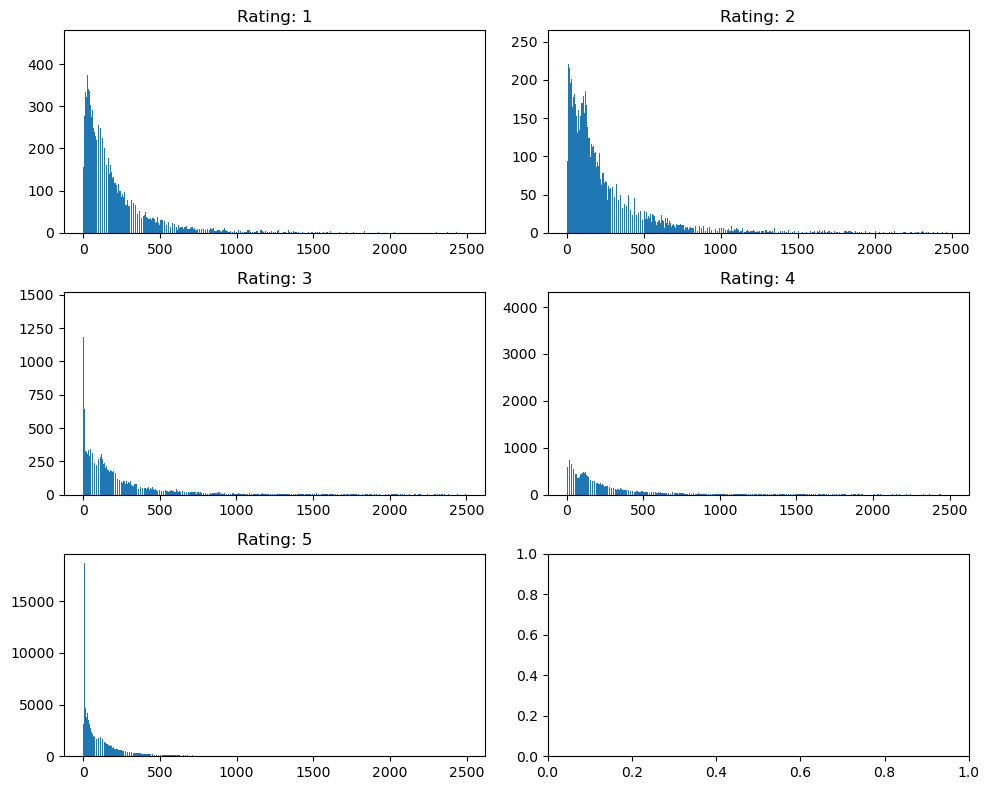

In [32]:
import seaborn as sns
plt.subplots(3,2, figsize=(10,8))
for i in range(1,6):
    len_dist = tech_simple2["length"][tech_simple2["overall"]==i].value_counts().reset_index()
    len_dist['count_norm']=len_dist['count']/len_dist["count"].sum()
    plt.subplot(3,2,i)
    plt.bar(len_dist["length"],len_dist['count'])
    # plt.bar(len_dist["length"],len_dist['count_norm'])
    plt.title(f"Rating: {i}")
plt.tight_layout()
plt.show()

Lets look at how the distribution changes as we reduce total length to 500 characters 

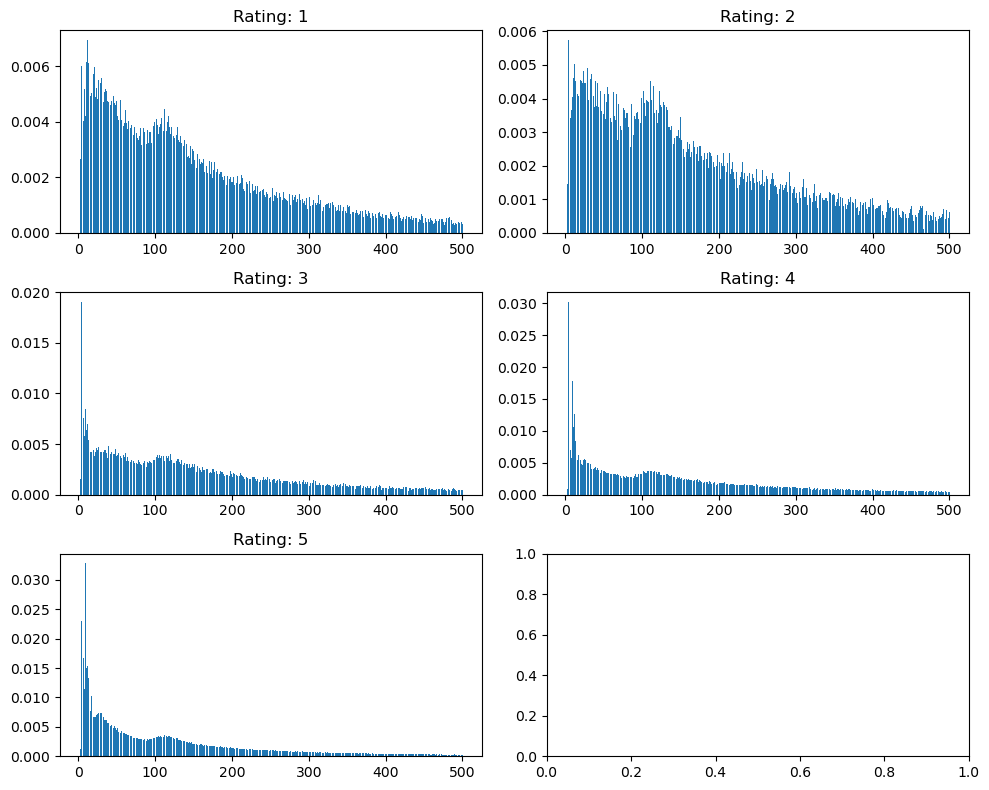

In [33]:
tech_simple3 = tech_simple[tech_simple["length"]<=500].copy()

plt.subplots(3,2, figsize=(10,8))
for i in range(1,6):
    len_dist = tech_simple3["length"][tech_simple3["overall"]==i].value_counts().reset_index()
    len_dist['count_norm']=len_dist['count']/len_dist["count"].sum()
    plt.subplot(3,2,i)
    # plt.bar(len_dist["length"],len_dist['count'])
    plt.bar(len_dist["length"],len_dist['count_norm'])
    plt.title(f"Rating: {i}")
plt.tight_layout()
plt.show()

Ignoring the outliers, the length of reviews seems to follow the same distribution overall regardless of rating. It is important to remember the vast majority of reviews are 5 stars, and we will need to eventually account for this bias in the data when modelling. 

In [34]:
tech_simple3["length"].describe()
short_car = tech_simple3.copy()


In [35]:
short_car

,overall,reviewText,summary,length
0,5.0,Looks even better in person. Be careful to not...,Can't stop won't stop looking at it,271
1,5.0,When you don't want to spend a whole lot of ca...,1,102
2,3.0,"so the case came on time, i love the design. I...",Its okay,257
3,2.0,DON'T CARE FOR IT. GAVE IT AS A GIFT AND THEY...,CASE,92
4,4.0,"I liked it because it was cute, but the studs ...",Cute!,150
...,...,...,...,...
1128429,4.0,Very good cell phone holster. Keeps my phone ...,Four Stars,79
1128430,1.0,Mediocre case protection. Clip is junk. Broke/...,One Star,62
1128431,3.0,my sons likes it. For the price it isn't too bad,Three Stars,48
1128432,4.0,Good for viewing. But doesn't have a button or...,Good,142


In [36]:
l_values, l_counts = np.unique(short_car['length'], return_counts=True)

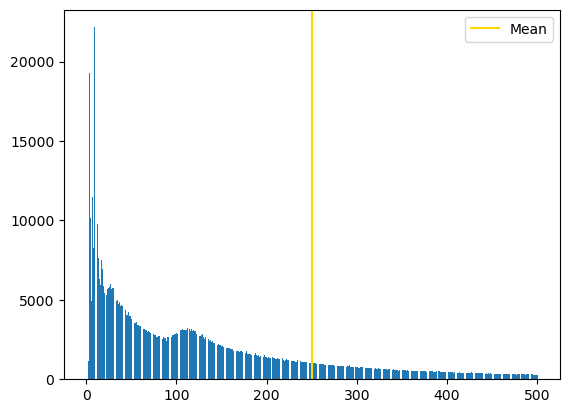

In [37]:
plt.figure()
plt.bar(l_values, l_counts)
plt.axvline(l_values.mean(), color='gold', label="Mean")

plt.legend()
plt.show()

In [38]:
# tokenising the reviews:
short_car['reviewText'].str.split(' ')

0          [Looks, even, better, in, person., Be, careful...
1          [When, you, don't, want, to, spend, a, whole, ...
2          [so, the, case, came, on, time,, i, love, the,...
3          [DON'T, CARE, FOR, IT., , GAVE, IT, AS, A, GIF...
4          [I, liked, it, because, it, was, cute,, but, t...
                                 ...                        
1128429    [Very, good, cell, phone, holster., , Keeps, m...
1128430    [Mediocre, case, protection., Clip, is, junk.,...
1128431    [my, sons, likes, it., For, the, price, it, is...
1128432    [Good, for, viewing., But, doesn't, have, a, b...
1128436                                        [i, love, it]
Name: reviewText, Length: 890444, dtype: object

In [39]:
short_car['reviewText'] = short_car['reviewText'].str.lower()


## First attempt at vectorising the text
We have not removed stop words etc and we also have many many spelling mistakes. I will show the full extent then for a first pass remove any tokens not in the english language.

In [40]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
X_1 = short_car["reviewText"].copy()
y_1= np.where(short_car['overall']>3, 1, 0)


X_train, X_test, y_train, y_test = train_test_split(X_1, y_1, test_size=0.2, random_state=42)

In [41]:
def bow_review(review_train,review_test,stop=None, ngrams=(0,1)): 
    # 1. Instantiate 
    bagofwords = CountVectorizer(stop_words=stop, ngram_range=ngrams)

    # 2. Fit 
    bagofwords.fit(review_train)

    # 3. Transform
    small_transformed_train = bagofwords.transform(review_train)
    small_transformed_test = bagofwords.transform(review_test)
    return(bagofwords, small_transformed_train, small_transformed_test)
bow1, doc_term_train_1, doc_term_test_1 = bow_review(X_train, X_test)

In [42]:
# these are now the features, they are the individual tokens
# bagofwords.get_feature_names()

bow1.get_feature_names()
corpus1 = bow1.get_feature_names()


print(doc_term_train_1.shape[0] * doc_term_train_1.shape[1] * doc_term_train_1.dtype.itemsize / 1e6)
print(doc_term_train_1.shape)

359613.90052
(712355, 63103)


In [43]:
term_frequencies = doc_term_train_1.sum(axis=0)
term_frequencies.shape

(1, 63103)

In [85]:
corpus1[53200:]

['storing',
 'storm',
 'storms',
 'stormtrooper',
 'stormtrouper',
 'stormy',
 'stornger',
 'storres',
 'story',
 'storybook',
 'storyleather',
 'storyline',
 'storys',
 'stought',
 'stound',
 'stoung',
 'stout',
 'stouter',
 'stoutly',
 'stoutness',
 'stove',
 'stoves',
 'stovetop',
 'stow',
 'stowage',
 'stowaway',
 'stowed',
 'stowing',
 'stows',
 'stp',
 'stpes',
 'stqrting',
 'str8',
 'strached',
 'straches',
 'straching',
 'stracthes',
 'strada',
 'straggling',
 'straght',
 'straghtforward',
 'straigh',
 'straight',
 'straightalk',
 'straightaway',
 'straightedge',
 'straighten',
 'straightened',
 'straightener',
 'straightening',
 'straightens',
 'straighter',
 'straightforward',
 'straightforwardly',
 'straightly',
 'straighttalk',
 'straigt',
 'strain',
 'strained',
 'strainer',
 'straining',
 'strains',
 'strait',
 'straitalk',
 'straitened',
 'straitening',
 'straits',
 'strand',
 'stranded',
 'strands',
 'strange',
 'strangely',
 'stranger',
 'strangers',
 'stranges',
 'str

We will discard all tokens not in english language


In [45]:
import nltk
nltk.download('words')

[nltk_data] Downloading package words to /Users/edo/nltk_data...
[nltk_data]   Package words is already up-to-date!


True

In [46]:
english_words = set(nltk.corpus.words.words())
unrecognized_tokens = [token for token in corpus1 if token.lower() not in english_words]
num_unrec = len(unrecognized_tokens)
num_unrec/len(corpus1)

0.7268751089488614

In [47]:
short_car2 = short_car.copy()
short_car2['reviewText'] = short_car2['reviewText'].apply(lambda x: ' '.join(word for word in x.split() if word in english_words))
short_car2

,overall,reviewText,summary,length
0,5.0,even better in be careful to not drop your pho...,Can't stop won't stop looking at it,271
1,5.0,when you want to spend a whole lot of cash but...,1,102
2,3.0,so the case came on i love the actually missin...,Its okay,257
3,2.0,care for gave it as a gift and they were with ...,CASE,92
4,4.0,i it because it was but the fall off easily an...,Cute!,150
...,...,...,...,...
1128429,4.0,very good cell phone my phone in yet is fairly,Four Stars,79
1128430,1.0,mediocre case clip is on,One Star,62
1128431,3.0,my sons for the price it too bad,Three Stars,48
1128432,4.0,good for but have a button or controller for h...,Good,142


In [48]:
short_car2.to_csv("../data/bag_of_words_Raw1.csv")

In [49]:
X_2 = short_car2["reviewText"].copy()
y_2= np.where(short_car2['overall']>3, 1, 0)


X_train2, X_test2, y_train2, y_test2 = train_test_split(X_2, y_2, test_size=0.2, random_state=42)

In [50]:
bow2, doc_term_train_2, doc_term_test_2 = bow_review(X_train2,X_test2, stop="english")

In [51]:
bow2.get_feature_names()
corpus2 = bow2.get_feature_names()

# small_transformed.toarray()
print(doc_term_train_2.shape[0] * doc_term_train_2.shape[1] * doc_term_train_2.dtype.itemsize / 1e6)
print(doc_term_train_2.shape)

89773.82652
(712355, 15753)


In [52]:
corpus2[:10]

['aa',
 'aam',
 'aback',
 'abacus',
 'abandon',
 'abandoned',
 'abbey',
 'aberration',
 'abet',
 'abhor']

It looks like we have removed the non-english words. This is good for a first pass, however we will need to return and address the issue of spelling mistakes in future.

Now, we can get the term term frequencies for each token in our corpus

In [53]:
# sometimes this block kills the kernel
term_frequencies2 = doc_term_train_2.sum(axis=0)
print(term_frequencies2.shape)
print(len(corpus2))
print(term_frequencies2[:][:1])
# my_df = pd.DataFrame(columns=bow2.get_feature_names(), data=doc_term_train_2.toarray())

my_df = pd.DataFrame.sparse.from_spmatrix(columns=bow2.get_feature_names(), data=doc_term_train_2)


(1, 15753)
15753
[[ 56   1   7 ...  44   4 123]]


In [54]:
my_df.head()

,aa,aam,aback,abacus,abandon,abandoned,abbey,aberration,abet,abhor,...,zipper,zipping,zippy,zircon,zo,zodiac,zombie,zone,zoo,zoom
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [55]:
freq_df = pd.DataFrame(columns=bow2.get_feature_names(), data=term_frequencies2)
freq_df = freq_df.T.sort_values(0, ascending=False)
freq_df.head(20)

,0
phone,173996
case,155353
great,138998
good,109670
like,82446
love,77359
works,73345
screen,69711
just,65664
nice,52259


In [56]:
total_obs = freq_df[0].sum()
total_obs

4921426

In [64]:
# Fitting a model
from sklearn.linear_model import LogisticRegression

logreg = LogisticRegression(C = 0.1, max_iter=1000)
logreg.fit(doc_term_train_2, y_train2)

# Training and test score
print(f"Train score: {logreg.score(doc_term_train_2, y_train2)}")
print(f"Test score: {logreg.score(doc_term_test_2, y_test2)}")



Train score: 0.8591629173656393
Test score: 0.8576610571118934


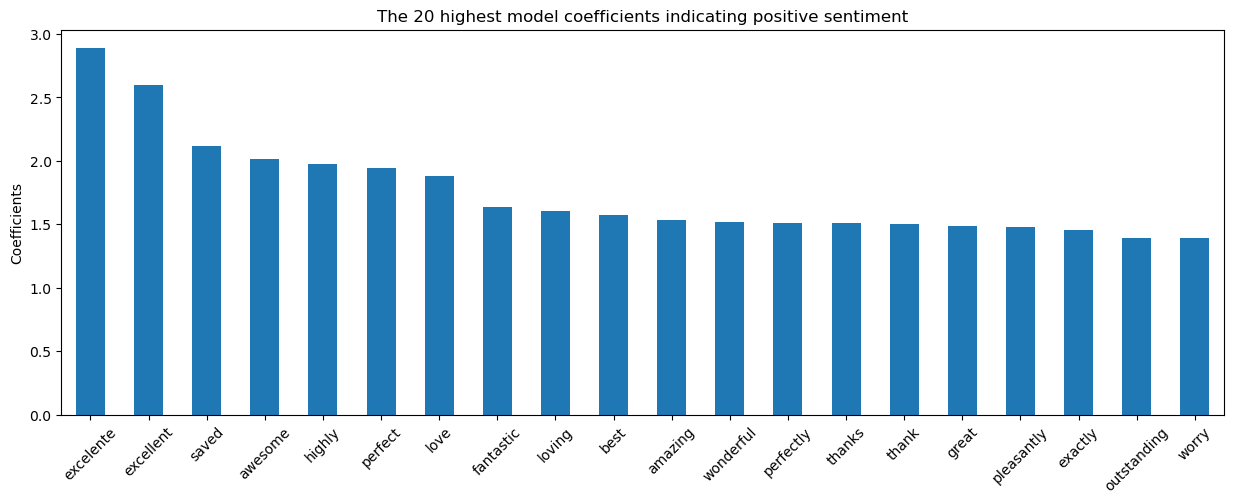

In [65]:
word_counts = pd.DataFrame(
    {"coefficients": logreg.coef_[0]},
    index=bow2.get_feature_names()
).sort_values("coefficients", ascending=False)

word_counts.head(20).plot(kind="bar", figsize=(15, 5), legend=False)

plt.title("The 20 highest model coefficients indicating positive sentiment")
plt.ylabel("Coefficients")
plt.xticks(rotation=45)
plt.show()

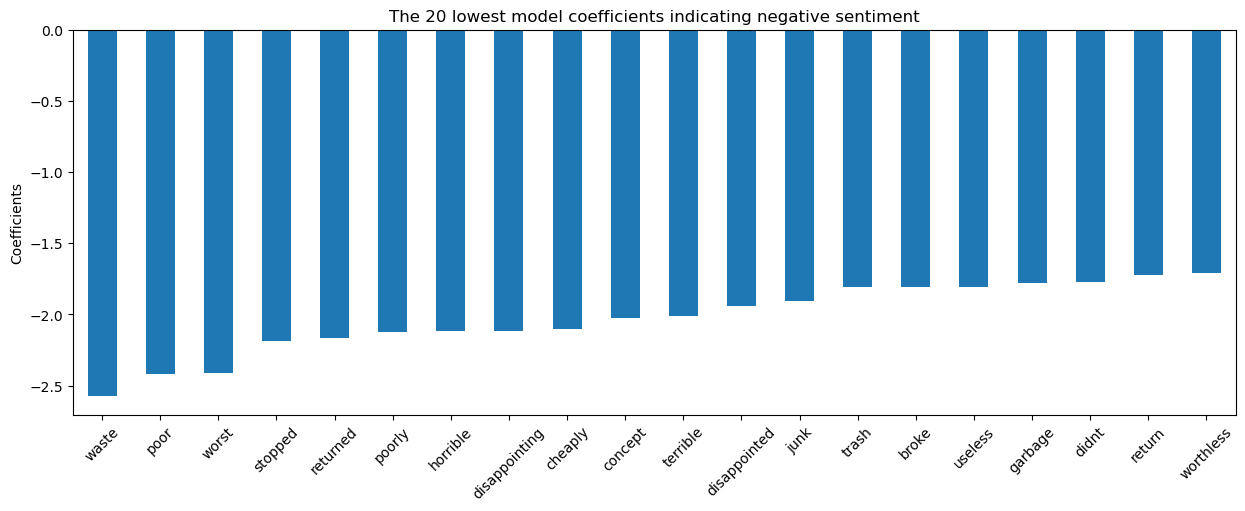

In [59]:
word_counts.sort_values("coefficients", ascending=True).head(20).plot(kind="bar", figsize=(15, 5), legend=False)
plt.title("The 20 lowest model coefficients indicating negative sentiment")
plt.ylabel("Coefficients")
plt.xticks(rotation=45)
plt.show()

In [60]:
# bow3, doc_term_train_3, doc_term_test_3 = bow_review(X_train2,X_test2, stop="english", ngrams=(1,3))

In [61]:
# bow3.get_feature_names()
# corpus3 = bow3.get_feature_names()

# # small_transformed.toarray()
# print(doc_term_train_3.shape[0] * doc_term_train_3.shape[1] * doc_term_train_3.dtype.itemsize / 1e6)
# print(doc_term_train_3.shape)

In [62]:
# # Fitting a model
# from sklearn.linear_model import LogisticRegression

# logreg = LogisticRegression(C = 0.1, max_iter=1000)
# logreg.fit(doc_term_train_3, y_train2)

# # Training and test score
# print(f"Train score: {logreg.score(doc_term_train_3, y_train2)}")
# print(f"Test score: {logreg.score(doc_term_test_3, y_test2)}")

